How to Organize the Single Notebook (project_final.ipynb)
Each major section should have a large Markdown heading (#) followed by code cells.


Section Title (Markdown)	What goes inside
 1. Introduction	Problem statement, project goals
 2. Imports & Setup	All import statements and helper functions
 3. Data Exploration (EDA)	Load CSVs, check missing files, plot distributions
 4. Data Preparation	Train/Val/Test split, normalization, dataset class
 5. Model Building	Define baseline CNN model (later extend if needed)
 6. Training Loop	Training code, save best model
 7. Evaluation	Confusion matrix, classification report, plots
 8. Error Analysis	Misclassified samples, Grad-CAM (optional)
 9. Final Judgement	Pick best model, justify choice
 10. Independent Evaluation	Compare your results with literature
 11. Conclusion	Wrap up and future directions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

#torch
import torch
from torch import nn

#torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import transforms
import torch.optim as optim
from torchmetrics.classification import Accuracy
from torchmetrics.classification import MulticlassPrecision, MulticlassRecall, MulticlassF1Score, MulticlassConfusionMatrix, BinaryAccuracy, MulticlassAccuracy
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, classification_report

In [49]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedGroupKFold

import random
from PIL import Image
from pathlib import Path
from torchinfo import summary
import copy

from sklearn.metrics import confusion_matrix
from matplotlib.ticker import MultipleLocator

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

mps


### Data Exploration

In [4]:
base_dir = os.getcwd()
image_dir = os.path.join(base_dir,'data','patch_images')
labels_main_dir = os.path.join(base_dir,"data","data_labels_mainData.csv")

In [5]:
labels_main = pd.read_csv(labels_main_dir)
labels_main.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [6]:
labels_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


In [7]:
labels_main['imagePath'] = labels_main['ImageName'].apply(lambda x: os.path.join(image_dir,x))
labels_main['imageExists'] = labels_main['imagePath'].apply(lambda x: os.path.exists(x))
labels_main.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,imagePath,imageExists
0,22405,1,22405.png,fibroblast,0,0,/Users/poornagunawardana/Desktop/Semester_4/CM...,True
1,22406,1,22406.png,fibroblast,0,0,/Users/poornagunawardana/Desktop/Semester_4/CM...,True
2,22407,1,22407.png,fibroblast,0,0,/Users/poornagunawardana/Desktop/Semester_4/CM...,True
3,22408,1,22408.png,fibroblast,0,0,/Users/poornagunawardana/Desktop/Semester_4/CM...,True
4,22409,1,22409.png,fibroblast,0,0,/Users/poornagunawardana/Desktop/Semester_4/CM...,True


In [8]:
print(labels_main.imageExists.value_counts())

imageExists
True    9896
Name: count, dtype: int64


In [9]:
print(f"Unique values in 'cellTypeName' :{labels_main.cellTypeName.unique()}")
print(f"Unique values in 'cellType' \t:{labels_main.cellType.unique()}")
print(f"Unique values in 'isCancerous \t:{labels_main.isCancerous.unique()}")

Unique values in 'cellTypeName' :['fibroblast' 'inflammatory' 'others' 'epithelial']
Unique values in 'cellType' 	:[0 1 3 2]
Unique values in 'isCancerous 	:[0 1]


In [10]:
print(f"No of patients :{labels_main.patientID.nunique()}")

No of patients :60


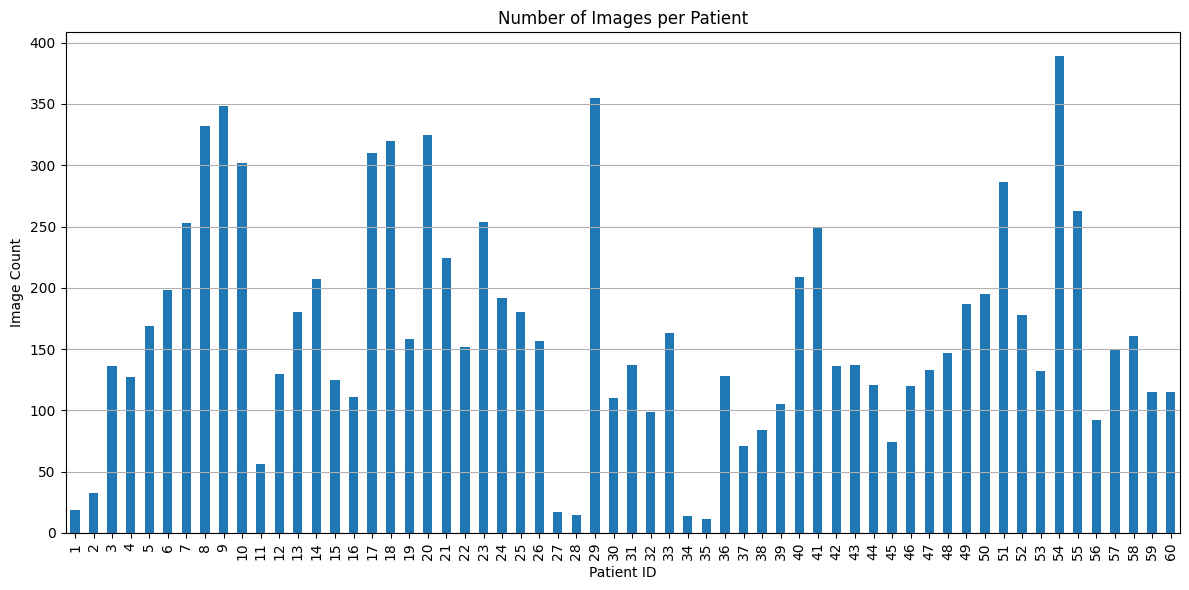

In [11]:
patient_image_counts = pd.DataFrame(labels_main.patientID.value_counts().sort_index())

patient_image_counts.plot(kind='bar', legend=False, figsize=(12, 6))
plt.title('Number of Images per Patient')
plt.xlabel('Patient ID')
plt.ylabel('Image Count')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

In [12]:
print(labels_main[['cellTypeName', 'cellType']].drop_duplicates().sort_values(by='cellType'))

     cellTypeName  cellType
0      fibroblast         0
11   inflammatory         1
449    epithelial         2
17         others         3


   cellTypeName  Raw_count  Raw_proportion
0    epithelial       4079            41.2
1  inflammatory       2543            25.7
2    fibroblast       1888            19.1
3        others       1386            14.0


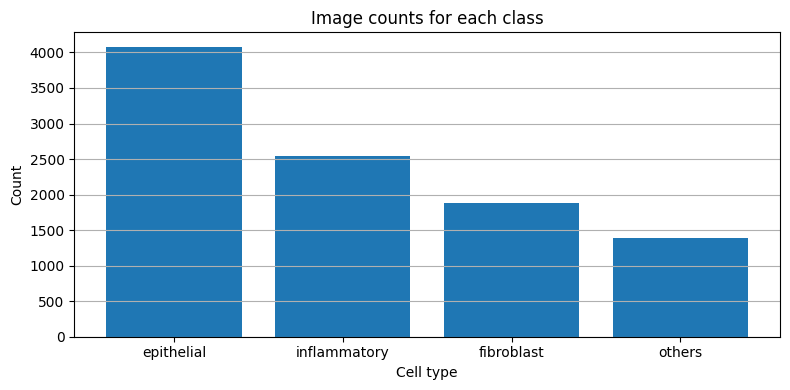

In [13]:
cellType_counts = labels_main['cellTypeName'].value_counts().reset_index()
cellType_counts.columns = ['cellTypeName', 'Raw_count']
cellType_counts['Raw_proportion'] = round((cellType_counts['Raw_count'] / cellType_counts['Raw_count'].sum()) * 100, 1)

print(cellType_counts)

plt.figure(figsize=[8,4])
plt.bar(cellType_counts['cellTypeName'],cellType_counts['Raw_count'])
plt.title('Image counts for each class')
plt.xlabel('Cell type')
plt.ylabel('Count')
plt.tight_layout()
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.show()

In [14]:
patient_cellType = labels_main.groupby(['patientID', 'cellTypeName']).size().unstack(fill_value=0)
patient_cellType.head()

cellTypeName,epithelial,fibroblast,inflammatory,others
patientID,,,,
1,0,11,6,2
2,0,8,18,7
3,0,53,73,10
4,0,39,81,7
5,35,25,103,6


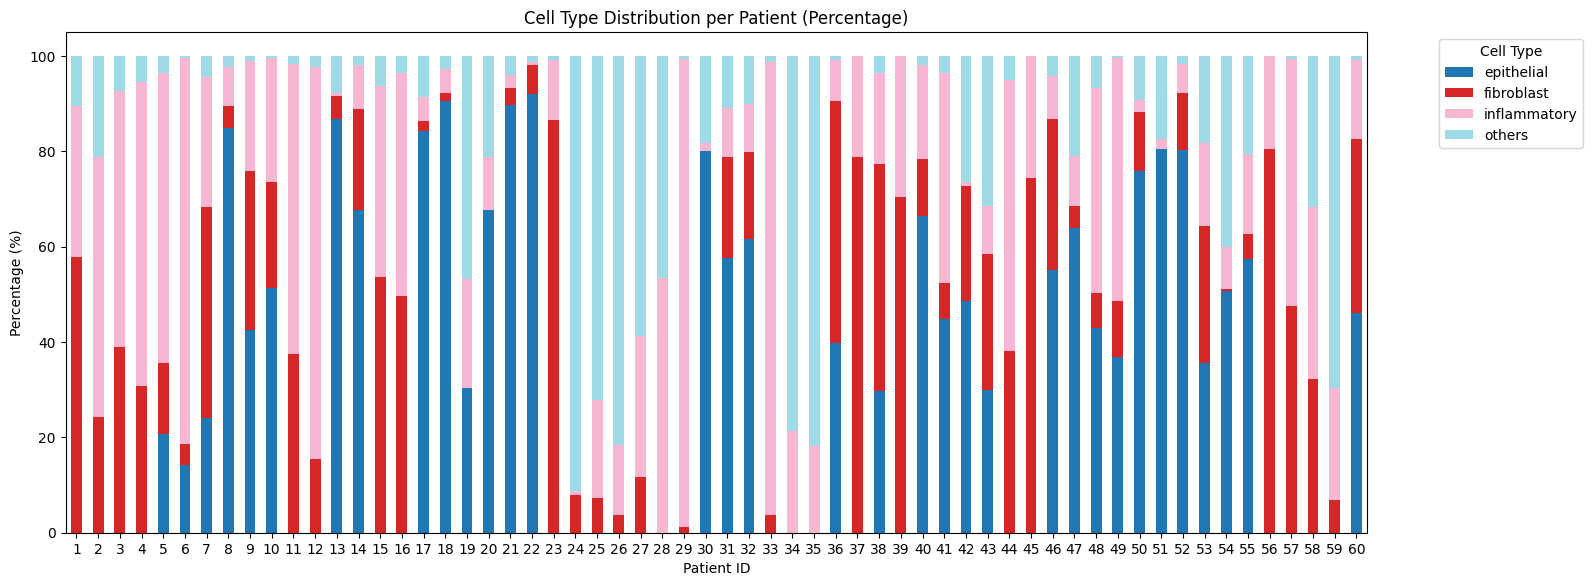

In [15]:
cell_percentages = patient_cellType.div(patient_cellType.sum(axis=1), axis=0) * 100

# Sort by patient ID for consistent plotting
cell_percentages = cell_percentages.sort_index()

# Plot
cell_percentages.plot(
    kind='bar',
    stacked=True,
    figsize=(16, 6),
    colormap='tab20'
)

plt.ylabel("Percentage (%)")
plt.xlabel("Patient ID")
plt.title("Cell Type Distribution per Patient (Percentage)")
plt.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

In [16]:
# explore how the cell type distribution varies with the being a cencerous cell or not

In [17]:
y = labels_main["cellType"]      
groups = labels_main["patientID"]      

# first split for test data
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=24)  

train_val_idx, test_idx = next(sgkf.split(labels_main, y, groups))               # take the first fold as test
df_train_val = labels_main.iloc[train_val_idx].reset_index(drop=True)
df_test      = labels_main.iloc[test_idx]     .reset_index(drop=True)

# second split for val data
y_tv      = df_train_val["cellType"]
groups_tv = df_train_val["patientID"]

sgkf_val = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=24)   # 1/4 ≈ 25 % of train_val ⇒ 20 % overall
train_idx, val_idx = next(sgkf_val.split(df_train_val, y_tv, groups_tv))

df_train = df_train_val.iloc[train_idx].reset_index(drop=True)
df_val   = df_train_val.iloc[val_idx].reset_index(drop=True)

In [18]:
# ▶ 3. Sanity checks ────────────────────────────────────────────────────────
def show_split_stats(name, dframe):
    print(f"{name:5}  patients={dframe['patientID'].nunique():3}  samples={len(dframe):5}")
    print(dframe["cellTypeName"].value_counts(normalize=True).mul(100).round(1), "\n")

for split_name, split_df in [("TRAIN", df_train), ("VAL", df_val), ("TEST", df_test)]:
    show_split_stats(split_name, split_df)

TRAIN  patients= 33  samples= 5772
cellTypeName
epithelial      36.1
inflammatory    29.1
fibroblast      20.1
others          14.7
Name: proportion, dtype: float64 

VAL    patients= 13  samples= 1927
cellTypeName
epithelial      54.7
inflammatory    21.7
fibroblast      12.7
others          10.9
Name: proportion, dtype: float64 

TEST   patients= 14  samples= 2197
cellTypeName
epithelial      42.8
fibroblast      22.1
inflammatory    20.3
others          14.8
Name: proportion, dtype: float64 



In [19]:
def show_split_counts(name, dframe):
    print(f"{name:5}  patients={dframe['patientID'].nunique():3}  samples={len(dframe):5}")
    print(dframe["cellTypeName"].value_counts(), "\n")

for split_name, split_df in [("TRAIN", df_train), ("VAL", df_val), ("TEST", df_test)]:
    show_split_counts(split_name, split_df)

TRAIN  patients= 33  samples= 5772
cellTypeName
epithelial      2085
inflammatory    1679
fibroblast      1159
others           849
Name: count, dtype: int64 

VAL    patients= 13  samples= 1927
cellTypeName
epithelial      1054
inflammatory     418
fibroblast       244
others           211
Name: count, dtype: int64 

TEST   patients= 14  samples= 2197
cellTypeName
epithelial      940
fibroblast      485
inflammatory    446
others          326
Name: count, dtype: int64 



In [20]:
train_percentages = df_train['cellTypeName'].value_counts(normalize=True).mul(100).round(1).reset_index()
train_percentages.columns=['cellTypeName','Train_proportion']
cellType_counts = cellType_counts.merge(train_percentages,left_on='cellTypeName',right_on='cellTypeName')

val_percentages = df_val['cellTypeName'].value_counts(normalize=True).mul(100).round(1).reset_index()
val_percentages.columns=['cellTypeName','Val_proportion']
cellType_counts = cellType_counts.merge(val_percentages,left_on='cellTypeName',right_on='cellTypeName')

test_percentages = df_test['cellTypeName'].value_counts(normalize=True).mul(100).round(1).reset_index()
test_percentages.columns=['cellTypeName','Test_proportion']
cellType_counts =  cellType_counts.merge(test_percentages,left_on='cellTypeName',right_on='cellTypeName')

cellType_counts
                                    

,cellTypeName,Raw_count,Raw_proportion,Train_proportion,Val_proportion,Test_proportion
0,epithelial,4079,41.2,36.1,54.7,42.8
1,inflammatory,2543,25.7,29.1,21.7,20.3
2,fibroblast,1888,19.1,20.1,12.7,22.1
3,others,1386,14.0,14.7,10.9,14.8


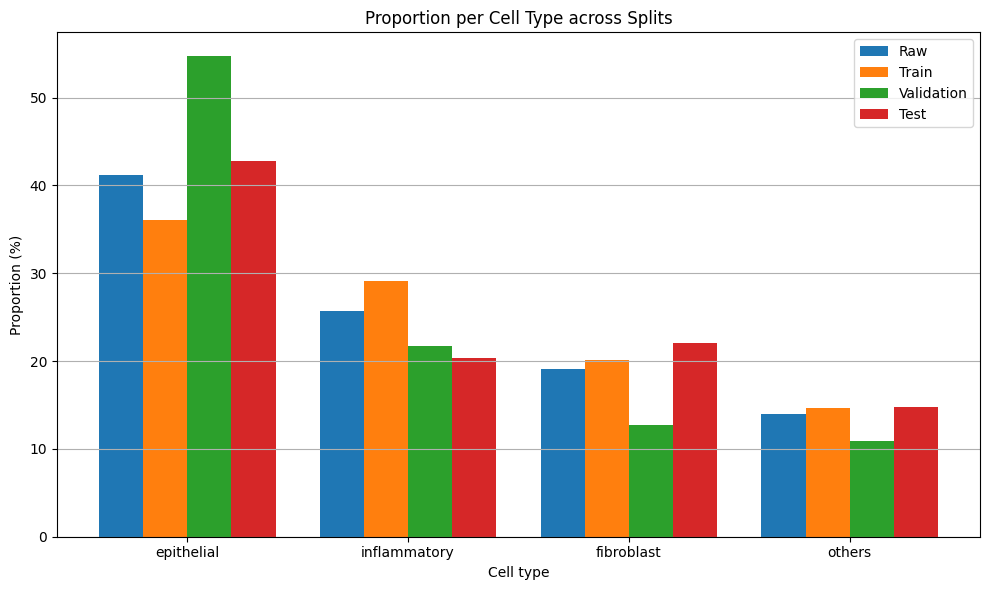

In [21]:
# Assume your dataframe is called df
categories = cellType_counts['cellTypeName']
x = np.arange(len(categories))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each group
ax.bar(x - width*1.5, cellType_counts['Raw_proportion'], width, label='Raw')
ax.bar(x - width/2, cellType_counts['Train_proportion'], width, label='Train')
ax.bar(x + width/2, cellType_counts['Val_proportion'], width, label='Validation')
ax.bar(x + width*1.5, cellType_counts['Test_proportion'], width, label='Test')

# Labels and title
ax.set_xlabel('Cell type')
ax.set_ylabel('Proportion (%)')
ax.set_title('Proportion per Cell Type across Splits')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
ax.grid(axis='y')
plt.tight_layout()
plt.show()

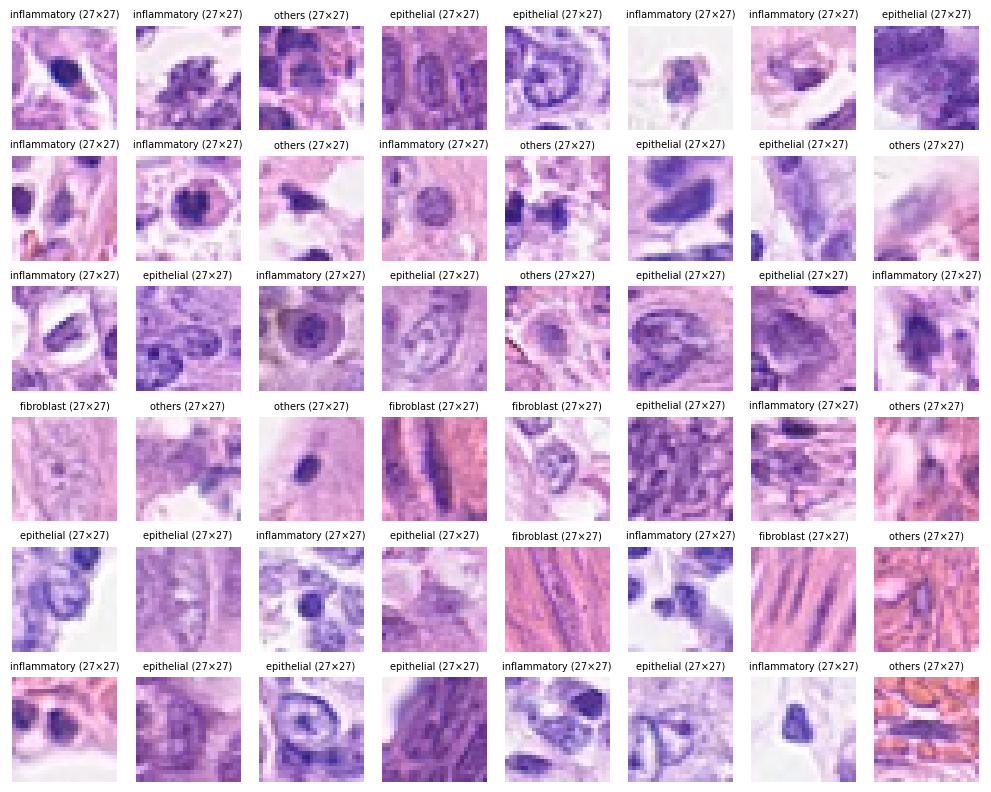

In [22]:
# visualize random set of images with cell type label and image sizes

# randomly select 54 images
sampled_df = labels_main.sample(n=54, random_state=42).reset_index(drop=True)

image_dir = Path('data/patch_images')

# plot
rows = 6
cols = 8
fig, axes = plt.subplots(rows, cols, figsize=(10, 8)) 
for ax, (_, row) in zip(axes.flatten(), sampled_df.iterrows()):
    img_path = image_dir / row['ImageName']
    
    img = Image.open(img_path)
    width, height = img.size
    ax.imshow(img)
    ax.set_title(f"{row['cellTypeName']} ({width}×{height})", fontsize=7)
    
    ax.axis('off')

plt.tight_layout()
plt.show()

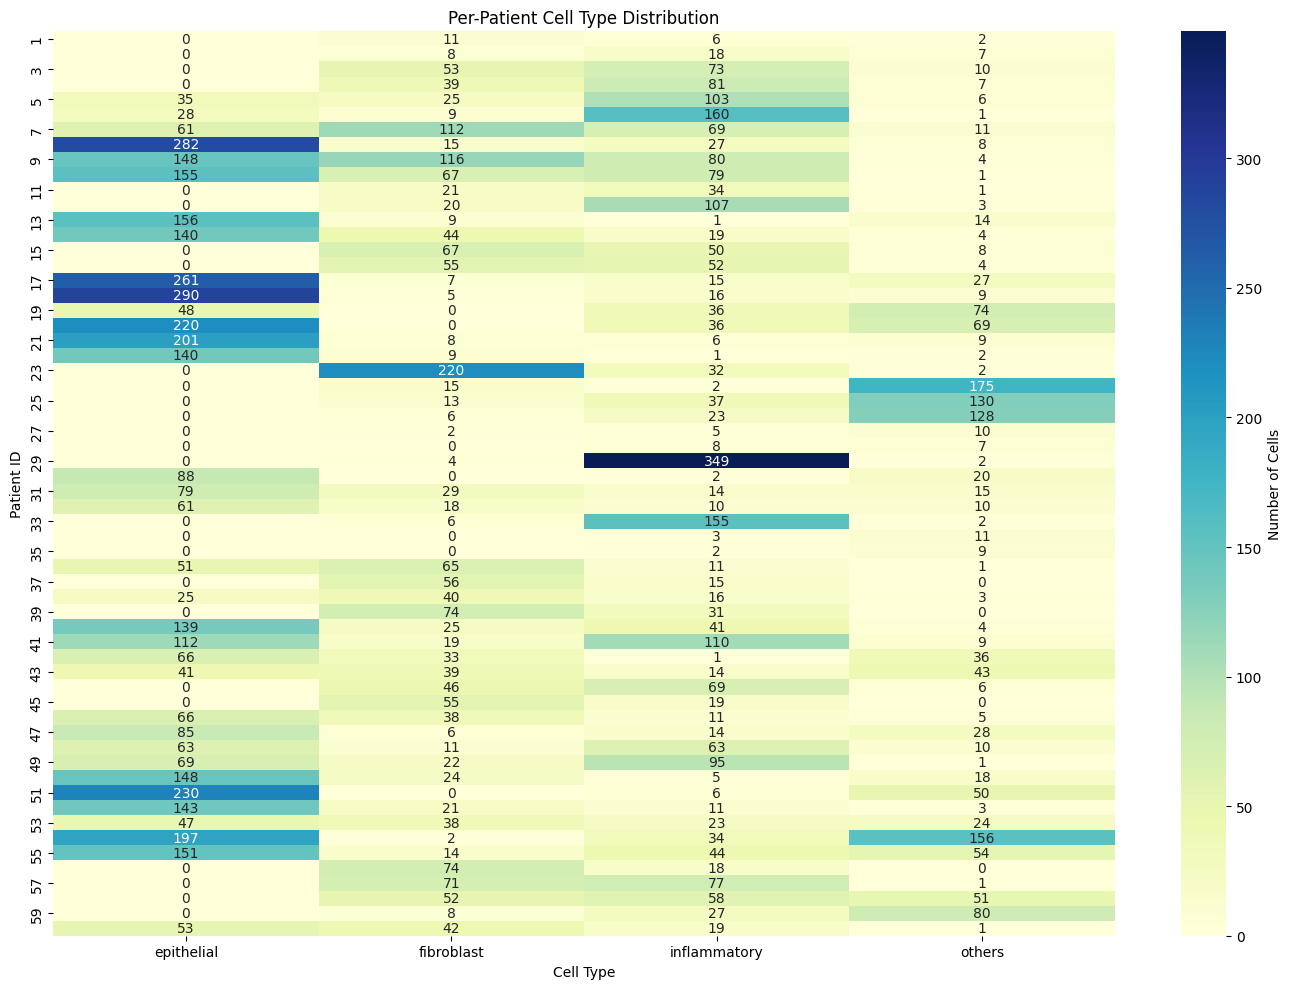

In [23]:
pivot_table = labels_main.pivot_table(index='patientID', 
                             columns='cellTypeName', 
                             values='ImageName', 
                             aggfunc='count', 
                             fill_value=0)

# ▶ 3. Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table, 
            annot=True, 
            fmt="d", 
            cmap="YlGnBu", 
            cbar_kws={'label': 'Number of Cells'})

plt.title('Per-Patient Cell Type Distribution')
plt.xlabel('Cell Type')
plt.ylabel('Patient ID')
plt.tight_layout()
plt.show()

In [24]:
class ColonCellDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = Image.open(row['imagePath']).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = row['cellType']
        return image, label


In [25]:
# function to calculate mean and standard deviation of train images

def get_mean_std(train_data):
    total_images= 0
    mean = torch.zeros(3)
    std = torch.zeros(3)

    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ])

    dataset = ColonCellDataset(train_data, transform=transform)
    loader = DataLoader(dataset, batch_size=128, shuffle=False)


    for images, _ in tqdm(loader,total=len(loader)):

        batch_size, num_channels, height, width = images.shape
        total_images += batch_size

        # Sum mean and std per channel
        mean += images.mean(dim=(0, 2, 3)) * batch_size
        std += images.std(dim=(0, 2, 3)) * batch_size

    mean /= total_images
    std /= total_images

    return mean, std

In [26]:
# calculating mean and standard diviation for train dataset
train_data_mean, train_data_std = get_mean_std(df_train)

print(f"Mean of train dataset : {train_data_mean}")
print(f"Standard deviation of train dataset : {train_data_std}")

100%|██████████| 46/46 [00:00<00:00, 56.39it/s]

Mean of train dataset : tensor([0.7617, 0.5884, 0.8002])
Standard deviation of train dataset : tensor([0.1533, 0.1738, 0.1080])


In [27]:
# Train-time: add augmentation
# train_transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(20),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=mean, std=std)
# ])

# baseline transform for train dataset
train_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_data_mean.tolist(), std=train_data_std.tolist())
])

# baseline trainsfor for validation dataset
val_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_data_mean.tolist(), std=train_data_std.tolist())
])

In [28]:
train_dataset = ColonCellDataset(df_train, transform=train_transform)
val_dataset   = ColonCellDataset(df_val, transform=val_transform)
test_dataset  = ColonCellDataset(df_test, transform=val_transform)

In [29]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=128, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False, num_workers=0)


In [30]:
print(f"No of batches in train data loader = {len(train_loader)}")
print(f"No of batches in val data loader = {len(val_loader)}")
print(f"No of batches in test data loader = {len(test_loader)}")

No of batches in train data loader = 46
No of batches in val data loader = 16
No of batches in test data loader = 18


In [31]:
# observing batch shape and several labels for one batch in train loader
images, labels = next(iter(train_loader))

print(f"Shape of a batch : {images.shape}")  
print(f"Sample labels for first 5 images of that batch : {labels[:5]}")    


Shape of a batch : torch.Size([128, 3, 64, 64])
Sample labels for first 5 images of that batch : tensor([0, 2, 1, 1, 1])


In [32]:
# temporary creating a subset to ensure the pipeline working properly

from torch.utils.data import Subset

small_train_dataset = Subset(train_dataset, range(100))
small_val_dataset = Subset(val_dataset,range(50))

small_train_loader = DataLoader(small_train_dataset, batch_size=16, shuffle=True, num_workers=0)
small_val_loader = DataLoader(small_val_dataset,batch_size=16,num_workers=0)

In [33]:
# images, labels = next(iter(small_train_loader))

# images.shape

# # model_0(images)

# img_single, label_single = images[0].unsqueeze(dim=0), labels[0]
# print(f"Single image shape: {img_single.shape}\n")

# model_0.eval()
# with torch.inference_mode():
#     pred = model_0(img_single.to(device))

In [34]:
# summary(model_0,input_size=[1,3,64,64])

## Helper functions

In [45]:
def set_seed(seed=42):

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [54]:
def multiclass_train_model_v0(model, train_data_loader, val_data_loader, loss_function, optimizer, num_classes, epoch_count, early_stop_count, device):

  """
  This function is intended to train and validate the model.
  Consist of both train and validation loops. Include an early stop criteria.
  
  Returns:
      Best model, train losses, train accuracies, validation losses, validation accuracies  
  """

  #setting model to device
  model = model.to(device)

  #tracking metrics and loss history
  train_losses, val_losses = [], []
  train_accuracies, val_accuracies = [], []

  #accuracy metrics
  train_accuracy_fn = Accuracy(task="multiclass", num_classes=num_classes, average='macro').to(device)
  val_accuracy_fn = Accuracy(task="multiclass", num_classes=num_classes, average='macro').to(device)

  best_val_loss = float('inf')
  best_model_weights = copy.deepcopy(model.state_dict())
  patience_counter = early_stop_count

  for epoch in range(epoch_count):

    print("-"*100)
    print(f"Epoch {epoch+1}/{epoch_count}")

    #--model training--
    model.train()
    train_accuracy_fn.reset()
    running_train_loss = 0.0

    for images, labels in tqdm(train_data_loader, desc="Training", leave=False):

      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = loss_function(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_train_loss += loss.item()*images.size(0)
      predictions = torch.argmax(outputs, dim=1)
      train_accuracy_fn.update(predictions, labels)

    avg_train_loss = running_train_loss/len(train_data_loader.dataset)
    avg_train_accuracy = train_accuracy_fn.compute().item()

    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    #--model validation--
    model.eval()

    val_accuracy_fn.reset()
    running_val_loss = 0.0

    with torch.no_grad():

      for images, labels in tqdm(val_data_loader, desc="Validation", leave=False):

        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = loss_function(outputs, labels)

        running_val_loss += loss.item() * images.size(0)

        predictions = torch.argmax(outputs, dim=1)
        val_accuracy_fn.update(predictions, labels)

      avg_val_loss = running_val_loss/len(val_data_loader.dataset)
      avg_val_accuracy = val_accuracy_fn.compute().item()

      val_losses.append(avg_val_loss)
      val_accuracies.append(avg_val_accuracy)

      print(f"Train loss : {avg_train_loss:.4f} \t| Train accuracy {avg_train_accuracy:.4f}")
      print(f"Val loss : {avg_val_loss:.4f} \t| Val accuracy {avg_val_accuracy:.4f}\n")
      print(f"Epoch {epoch+1} | Val loss: {avg_val_loss:.4f} | Best so far: {best_val_loss:.4f} | Patience left: {patience_counter}")
      
      #early stop check
      if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model.state_dict())
        patience_counter = early_stop_count
      else:
        patience_counter -= 1
        if patience_counter == 0:
          print("Early stopping triggered..")
          break
  
  #loading the best model weights
  model.load_state_dict(best_model_weights)

  #return predictions and metrics
  return model, train_losses, train_accuracies, val_losses, val_accuracies

In [36]:
def evaluate_model_predictions(model, val_data_loader, device):

    """
    This function is defined to make the predictions from a given model. 
    Main usage is to make predictions, to be used in evaluation metrics.

    Returns :
        Predictions, Targets
    """

    model.eval()

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, labels in tqdm(val_data_loader, desc="Evaluation", leave=False):

            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)

            all_predictions.append(predictions.cpu())
            all_targets.append(labels.cpu())
        
        all_predictions = torch.cat(all_predictions)
        all_targets = torch.cat(all_targets)

    return all_predictions, all_targets

In [50]:
def plot_loss_and_accuracy_cellTypeClassification(train_losses, train_accuracies, val_losses, val_accuracies):

    """ 
    This function is used to plot train and validation loss and accuracy curves for cell type classification.
    """

    plt.figure(figsize=(15, 5))
  
    plt.subplot(1,2,1)
    plt.plot(train_losses,label="Train loss")
    plt.plot(val_losses,label="Validation loss")
    plt.xlabel("No of epoches")
    plt.ylabel("Loss")
    plt.title("Loss")
    plt.grid(axis='x')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MultipleLocator(1)) 

    plt.subplot(1,2,2)
    plt.plot(train_accuracies,label="Train accuracy")
    plt.plot(val_accuracies,label="Validation accuracy")
    plt.xlabel("No of epoches")
    plt.ylabel("Accuracy")
    plt.title("Accuracy")
    plt.grid(axis='x')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MultipleLocator(1))

    plt.tight_layout()
    plt.show()

In [38]:
def plot_confusion_metrics_cellTypeClassification(predictions, targets):

  """ 
  This function is defined to plot the confusion metrics for cell type classification.
  """

  cm_metric = MulticlassConfusionMatrix(num_classes=4)
  cm = cm_metric(predictions,targets)
  cm = cm.numpy()

  #plot
  plt.figure(figsize=(8, 5))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
              xticklabels=["fibroblast", "inflammatory","epithelial","others"], 
              yticklabels=["fibroblast", "inflammatory","epithelial","others"])
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix")
  plt.show()

In [39]:
def evaluate_per_class_metrics_cellTypeClassification(predictions, targets):

    """ 
    This function is defined to generate the classification report for cell type classification.
    """

    class_names = ["fibroblast", "inflammatory","epithelial","others"]
    print("Classification Report:\n")
    report = classification_report(y_true=targets, y_pred=predictions, target_names=class_names, digits=3)
    print(report)

In [40]:
def calculate_macro_accuracy(predictions, targets):

    """This function is defined to calculate the macro accuracy for classification."""

    cm = confusion_matrix(y_true=targets, y_pred=predictions)
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    macro_acc = np.mean(per_class_accuracy)
    print(f"Macro Accuracy: {macro_acc:.4f}")


In [41]:
def generate_evaluation_metrics(train_losses, train_accuracies, val_losses, val_accuracies, predictions, targets):

    """ 
    This generates/calculate evaluation metrics/plots.
    """

    plot_loss_and_accuracy_cellTypeClassification(train_losses=train_losses,train_accuracies=train_accuracies,
                                                  val_losses=val_losses, val_accuracies=val_accuracies)
    
    plot_confusion_metrics_cellTypeClassification(predictions=predictions, targets=targets)

    evaluate_per_class_metrics_cellTypeClassification(predictions=predictions, targets=targets)

    calculate_macro_accuracy(predictions=predictions, targets=targets)

## Models

In [42]:
class CellTypeClassification_CNNModel_V0(nn.Module):

  def __init__(self):
    super().__init__()

    # Convolutional Block 1
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)    
    )

    # Convolutional Block 2
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # Convolutional Block 3
    self.conv_block3 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )


    # Fully connected layers
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=128*8*8,
                  out_features=4)
    )

  def forward(self, x: torch.Tensor):
        # x = self.conv_block1(x)
        # print(x.shape)
        # x = self.conv_block2(x)
        # print(x.shape)
        # x = self.conv_block3(x)
        # print(x.shape)
        # x = self.classifier(x)
        # print(x.shape)
        # return x
        return self.classifier(self.conv_block3(self.conv_block2(self.conv_block1(x)))) 

## Training and validating models

In [52]:
set_seed(seed=42)

In [58]:
#instantiating a model
model_0 = CellTypeClassification_CNNModel_V0()

#defining loss function and  optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_0.parameters(), lr=0.001)

#model training
best_model, train_losses, train_accuracies, val_losses, val_accuracies = multiclass_train_model_v0(
    model=model_0,
    train_data_loader=train_loader,
    val_data_loader=val_loader,
    loss_function=loss_fn,
    optimizer=optimizer,
    num_classes=4,
    epoch_count=30,
    early_stop_count=10,
    device=device
)

#making predictions for val data with best model
val_predictions, val_targets = evaluate_model_predictions(model=best_model, val_data_loader=val_loader, device=device)

----------------------------------------------------------------------------------------------------
Epoch 1/30


Train loss : 0.9096 	| Train accuracy 0.5397
Val loss : 0.7480 	| Val accuracy 0.5803

Epoch 1 | Val loss: 0.7480 | Best so far: inf | Patience left: 10
----------------------------------------------------------------------------------------------------
Epoch 2/30


Train loss : 0.6777 	| Train accuracy 0.6624
Val loss : 0.7499 	| Val accuracy 0.5910

Epoch 2 | Val loss: 0.7499 | Best so far: 0.7480 | Patience left: 10
----------------------------------------------------------------------------------------------------
Epoch 3/30


Train loss : 0.6737 	| Train accuracy 0.6764
Val loss : 0.7770 	| Val accuracy 0.5980

Epoch 3 | Val loss: 0.7770 | Best so far: 0.7480 | Patience left: 9
----------------------------------------------------------------------------------------------------
Epoch 4/30


Train loss : 0.5937 	| Train accuracy 0.7151
Val loss : 0.6613 	| Val accuracy 0.6246

Epoch 4 | Val loss: 0.6613 | Best so far: 0.7480 | Patience left: 8
----------------------------------------------------------------------------------------------------
Epoch 5/30


Train loss : 0.5603 	| Train accuracy 0.7380
Val loss : 0.7732 	| Val accuracy 0.5933

Epoch 5 | Val loss: 0.7732 | Best so far: 0.6613 | Patience left: 10
----------------------------------------------------------------------------------------------------
Epoch 6/30


Train loss : 0.5308 	| Train accuracy 0.7520
Val loss : 0.6973 	| Val accuracy 0.6324

Epoch 6 | Val loss: 0.6973 | Best so far: 0.6613 | Patience left: 9
----------------------------------------------------------------------------------------------------
Epoch 7/30


Train loss : 0.4958 	| Train accuracy 0.7702
Val loss : 0.6589 	| Val accuracy 0.6694

Epoch 7 | Val loss: 0.6589 | Best so far: 0.6613 | Patience left: 8
----------------------------------------------------------------------------------------------------
Epoch 8/30


Train loss : 0.4594 	| Train accuracy 0.7864
Val loss : 0.7352 	| Val accuracy 0.6316

Epoch 8 | Val loss: 0.7352 | Best so far: 0.6589 | Patience left: 10
----------------------------------------------------------------------------------------------------
Epoch 9/30


Train loss : 0.4143 	| Train accuracy 0.8170
Val loss : 0.7723 	| Val accuracy 0.6415

Epoch 9 | Val loss: 0.7723 | Best so far: 0.6589 | Patience left: 9
----------------------------------------------------------------------------------------------------
Epoch 10/30


Train loss : 0.3859 	| Train accuracy 0.8338
Val loss : 0.7687 	| Val accuracy 0.6301

Epoch 10 | Val loss: 0.7687 | Best so far: 0.6589 | Patience left: 8
----------------------------------------------------------------------------------------------------
Epoch 11/30


Train loss : 0.3384 	| Train accuracy 0.8541
Val loss : 0.8731 	| Val accuracy 0.6296

Epoch 11 | Val loss: 0.8731 | Best so far: 0.6589 | Patience left: 7
----------------------------------------------------------------------------------------------------
Epoch 12/30


Train loss : 0.3274 	| Train accuracy 0.8574
Val loss : 0.8557 	| Val accuracy 0.6197

Epoch 12 | Val loss: 0.8557 | Best so far: 0.6589 | Patience left: 6
----------------------------------------------------------------------------------------------------
Epoch 13/30


Train loss : 0.3198 	| Train accuracy 0.8629
Val loss : 0.7404 	| Val accuracy 0.6389

Epoch 13 | Val loss: 0.7404 | Best so far: 0.6589 | Patience left: 5
----------------------------------------------------------------------------------------------------
Epoch 14/30


Train loss : 0.2516 	| Train accuracy 0.8911
Val loss : 0.9212 	| Val accuracy 0.6012

Epoch 14 | Val loss: 0.9212 | Best so far: 0.6589 | Patience left: 4
----------------------------------------------------------------------------------------------------
Epoch 15/30


Train loss : 0.2279 	| Train accuracy 0.9007
Val loss : 1.0293 	| Val accuracy 0.6087

Epoch 15 | Val loss: 1.0293 | Best so far: 0.6589 | Patience left: 3
----------------------------------------------------------------------------------------------------
Epoch 16/30


Train loss : 0.2083 	| Train accuracy 0.9126
Val loss : 0.9754 	| Val accuracy 0.6126

Epoch 16 | Val loss: 0.9754 | Best so far: 0.6589 | Patience left: 2
----------------------------------------------------------------------------------------------------
Epoch 17/30


Train loss : 0.1561 	| Train accuracy 0.9362
Val loss : 1.0010 	| Val accuracy 0.6268

Epoch 17 | Val loss: 1.0010 | Best so far: 0.6589 | Patience left: 1
Early stopping triggered..


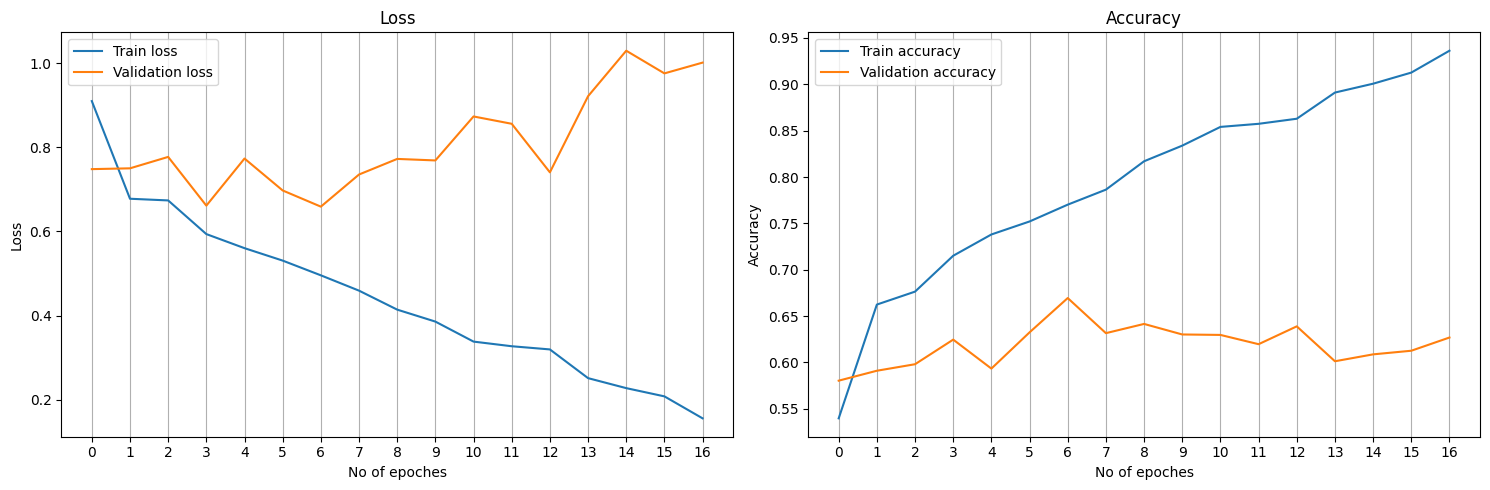

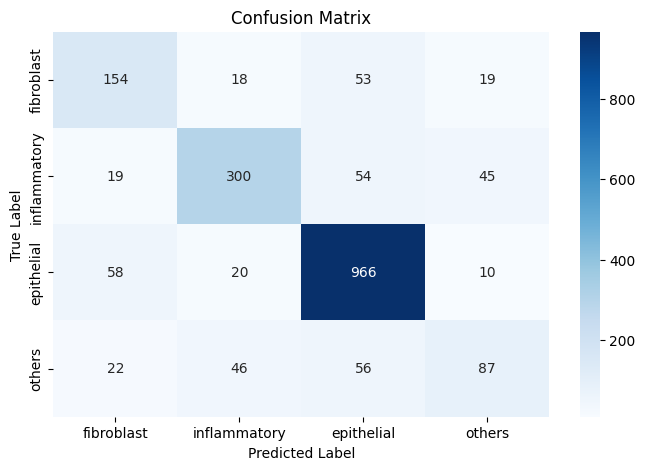

Classification Report:

              precision    recall  f1-score   support

  fibroblast      0.609     0.631     0.620       244
inflammatory      0.781     0.718     0.748       418
  epithelial      0.856     0.917     0.885      1054
      others      0.540     0.412     0.468       211

    accuracy                          0.782      1927
   macro avg      0.696     0.669     0.680      1927
weighted avg      0.774     0.782     0.776      1927

Macro Accuracy: 0.6694


In [59]:
generate_evaluation_metrics(train_losses=train_losses, train_accuracies=train_accuracies,
                            val_losses=val_losses, val_accuracies=val_accuracies,
                            predictions=val_predictions, targets=val_targets)